In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.ensemble import IsolationForest
from tqdm import tqdm
from scipy.stats import pearsonr
from seaborn import heatmap

In [2]:
df = pd.read_csv('evraz_data.csv', sep=';', decimal=",")
y_cols = ['химшлак последний Al2O3', 'химшлак последний CaO', 
          'химшлак последний FeO', 'химшлак последний MgO',
          'химшлак последний MnO', 'химшлак последний R',
          'химшлак последний SiO2']
df

,Unnamed: 0,nplv,DT,МАРКА,ПРОФИЛЬ,t вып-обр,t обработка,t под током,t продувка,ПСН гр.,...,химшлак первый MnO_1,химшлак первый R_1,химшлак первый SiO2_1,химшлак последний Al2O3,химшлак последний CaO,химшлак последний FeO,химшлак последний MgO,химшлак последний MnO,химшлак последний R,химшлак последний SiO2
0,0,г6837?3<87?,2070-06-21 00:14:00,Э76ХФ,Р65,29.0,45.366667,24.400000,41.033333,NaN,...,0.12,2.6,NaN,NaN,53.4,1.0,5.8,0.15,2.6,NaN
1,1,г683863<886,2070-06-21 01:07:00,Э76ХФ,Р65,26.0,44.066667,13.866667,44.066667,NaN,...,0.14,2.2,NaN,NaN,59.3,0.6,4.1,0.11,2.3,NaN
2,2,г683863<887,2070-06-21 02:00:00,Э76ХФ,Р65,24.0,43.350000,17.950000,43.350000,NaN,...,0.12,2.6,NaN,NaN,57.2,0.5,8.1,0.13,2.3,NaN
3,3,г683863<888,2070-06-21 02:58:00,Э76ХФ,Р65,17.0,46.183333,19.816667,46.183333,NaN,...,0.11,2.4,NaN,NaN,60.3,0.5,6.3,0.12,2.6,NaN
4,4,г683863<889,2070-06-21 03:50:00,Э76ХФ,Р65,20.0,48.500000,17.033333,48.500000,NaN,...,0.12,2.4,NaN,NaN,60.3,0.6,4.5,0.09,2.5,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7036,7036,г68386398<;,2071-04-21 19:50:00,Э90ХАФ,Р65,41.0,42.333333,23.200000,42.166667,3.380628,...,0.10,2.6,22.2,7.0,60.6,0.4,6.2,0.06,2.7,22.8
7037,7037,г68386398<<,2071-04-21 20:45:00,Э90ХАФ,Р65,36.0,46.533333,16.183333,46.383333,NaN,...,0.10,2.2,24.5,4.9,53.0,0.5,11.1,0.25,2.4,22.3
7038,7038,г68386398<=,2071-04-21 21:34:00,Э90ХАФ,Р65,42.0,47.566667,23.016667,47.100000,2.263004,...,0.13,2.7,20.0,5.2,55.4,0.7,6.7,0.13,2.2,25.0
7039,7039,г68386398<>,2071-04-21 22:25:00,Э90ХАФ,Р65,45.0,46.033333,17.533333,45.683333,3.000000,...,0.18,2.1,24.5,4.9,55.1,0.4,8.9,0.16,2.1,26.0


## Удаление пропусков

In [3]:
# Убираем столбцы с NaN > 50%

exclude_columns = []
for column in df.columns:
    nas = df[column].isna().sum()
    if nas > len(df)//2:
        exclude_columns.append(column)
    
df = df.drop(columns=exclude_columns)
print('Убраны столбцы с NaN > 50%:', exclude_columns)
print(df.shape)

Убраны столбцы с NaN > 50%: ['N2 (интенс.)', 'расход газ  N2', 'расход C пров.', 'сыпуч кварцит', 'сыпуч  кокс. мелочь (сух.)', 'ферспл FeMo', 'ферспл FeSi-75', 'ферспл FeV азот.', 'ферспл  Ni H1 пласт.', 'ферспл  ферванит']
(7041, 75)


In [4]:
# Убираем столбцы с одним значением и со 100% уникальностью
exclude_columns = []
for column in df.columns:
    nunique = df[column].nunique()
    if nunique == 1 or nunique == len(df):
        exclude_columns.append(column)

df = df.drop(columns=exclude_columns)
print("Убраны столбцы с одним значением и со 100% уникальностью:", exclude_columns)
print(df.shape)

Убраны столбцы с одним значением и со 100% уникальностью: ['Unnamed: 0', 'nplv', 'DT', 'произв  количество плавок', 'произв количество плавок (цел)']
(7041, 70)


'произв количество обработок' имеет сильный дисбалланс. 
Это поле стоит убрать (возможно, также убрать и строки со значениями != 1.

In [5]:
df.groupby(by='произв количество обработок', as_index=False).agg({'произв количество обработок': pd.Series.count})

,произв количество обработок
0,6391.0
1,48.0
2,5.0


In [6]:
df = df.drop(columns='произв количество обработок')


Тестирование на бейзлайн-моделях говорит о негативном влиянии кат признаков (марка и профиль) 
на точности моделей. Пока не будем их использовать. Нельзя так же не отметить сильный дисбалланс по этим признакам

In [7]:
another_title = f'другое ({df["МАРКА"].nunique() - 2} видов)' 
df['МАРКА'] = df['МАРКА'].apply(lambda row: row if row in ['Э76ХФ', 'Э90ХАФ'] else another_title)
df.groupby(by='МАРКА').agg({'МАРКА': pd.Series.count})

,МАРКА
МАРКА,
Э76ХФ,4953
Э90ХАФ,1384
другое (16 видов),704


In [8]:
df = df.drop(columns=['МАРКА'])

In [9]:
another_title = f'другое ({df["ПРОФИЛЬ"].nunique() - 1} видов)'
df['ПРОФИЛЬ'] = df['ПРОФИЛЬ'].apply(lambda row: row if row == 'Р65' else another_title)
df.groupby(by='ПРОФИЛЬ').agg({'ПРОФИЛЬ': pd.Series.count})

,ПРОФИЛЬ
ПРОФИЛЬ,
Р65,6427
другое (17 видов),614


In [10]:
df = df.drop(columns='ПРОФИЛЬ')
 

In [11]:
# Удаление строк с NaN > 33%
row_indexes_to_exclude = []

number_of_columns_in_dataframe = len(df.columns)
for index, row in df.iterrows():
    NaN_count = row.isna().sum()
    if NaN_count > number_of_columns_in_dataframe*(1/3):
        row_indexes_to_exclude.append(index)

df = df.drop(df.index[row_indexes_to_exclude])
print('Удаление строк с NaN > 33%, размер теперь:', df.shape)

Удаление строк с NaN > 33%, размер теперь: (6443, 67)


In [12]:
# Много пропусков в колонках 'химшлак последний Al2O3' и 'химшлак последний SiO2'
# Сделаем из них доп кат переменные
al2o3_is_na_col = df['химшлак первый Al2O3_1'].isna().astype(int)
al2o3_is_na_col.name = 'химшлак первый Al2O3_1 == NaN'
sio2_is_na_col = df['химшлак первый SiO2_1'].isna().astype(int)
sio2_is_na_col.name = 'химшлак первый SiO2_1 == NaN'
print("Созданы кат переменные под отсуствие полей 'химшлак первый Al2O3_1' и 'химшлак первый SiO2_1'")

Созданы кат переменные под отсуствие полей 'химшлак первый Al2O3_1' и 'химшлак первый SiO2_1'


In [13]:
# Заполняем NaN'ы средними

for column in df.columns:
    df[column].fillna(df[column].mean(), inplace=True)
print("NaN'ы заполенеы средними")
        

NaN'ы заполенеы средними


In [14]:
# Удаленние выбросов
isfor = IsolationForest()
isfor.fit(df)
isfor_pred = isfor.predict(df)

df = df[isfor_pred==1]
al2o3_is_na_col = al2o3_is_na_col[isfor_pred==1]
sio2_is_na_col = sio2_is_na_col[isfor_pred==1]

print("Удалены выбросы, размер теперь:", df.shape)

Удалены выбросы, размер теперь: (6285, 67)


In [15]:
# Отделяем y

X = df.drop(columns=y_cols)
y = df.filter(y_cols)

print('X', X.shape)
print('y', y.shape)

X (6285, 60)
y (6285, 7)


### Текущие распределения целевых значений

(0.0, 1.0, 0.0, 1.0)

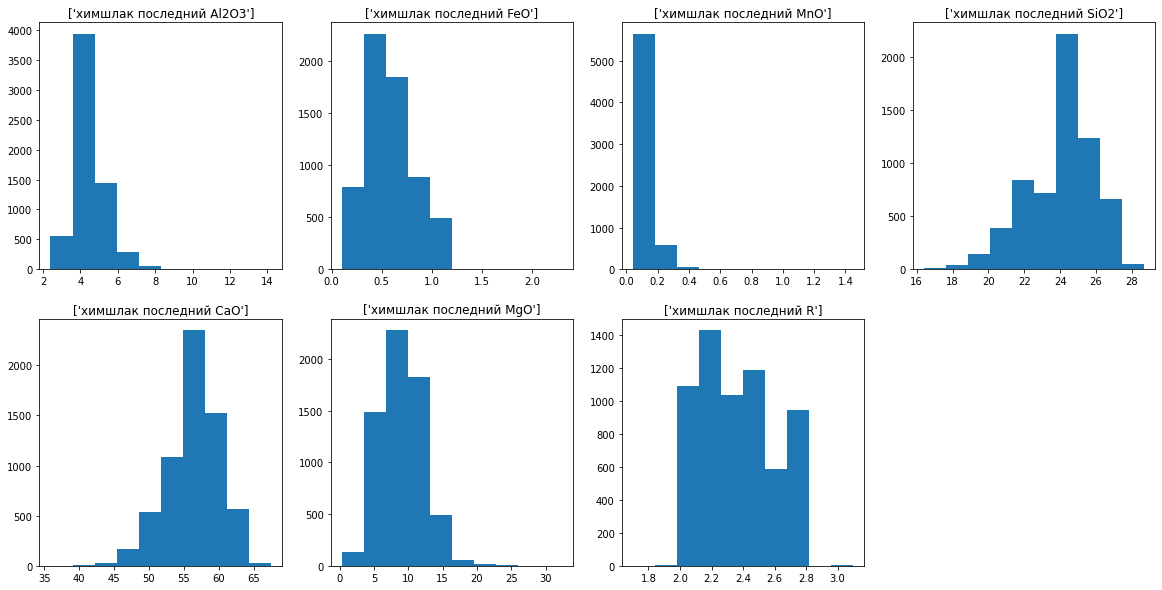

In [16]:
fig, axs = plt.subplots(2, 4, figsize=(20,10))
for i in range(len(y_cols)):
    axs[i%2, i//2].hist(y[y_cols[i]])
    axs[i%2, i//2].set_title([y_cols[i]])
axs[-1,-1].axis('off')

## Поиск линейно зависимых столбцов

100%|██████████| 60/60 [00:00<00:00, 67.78it/s] 


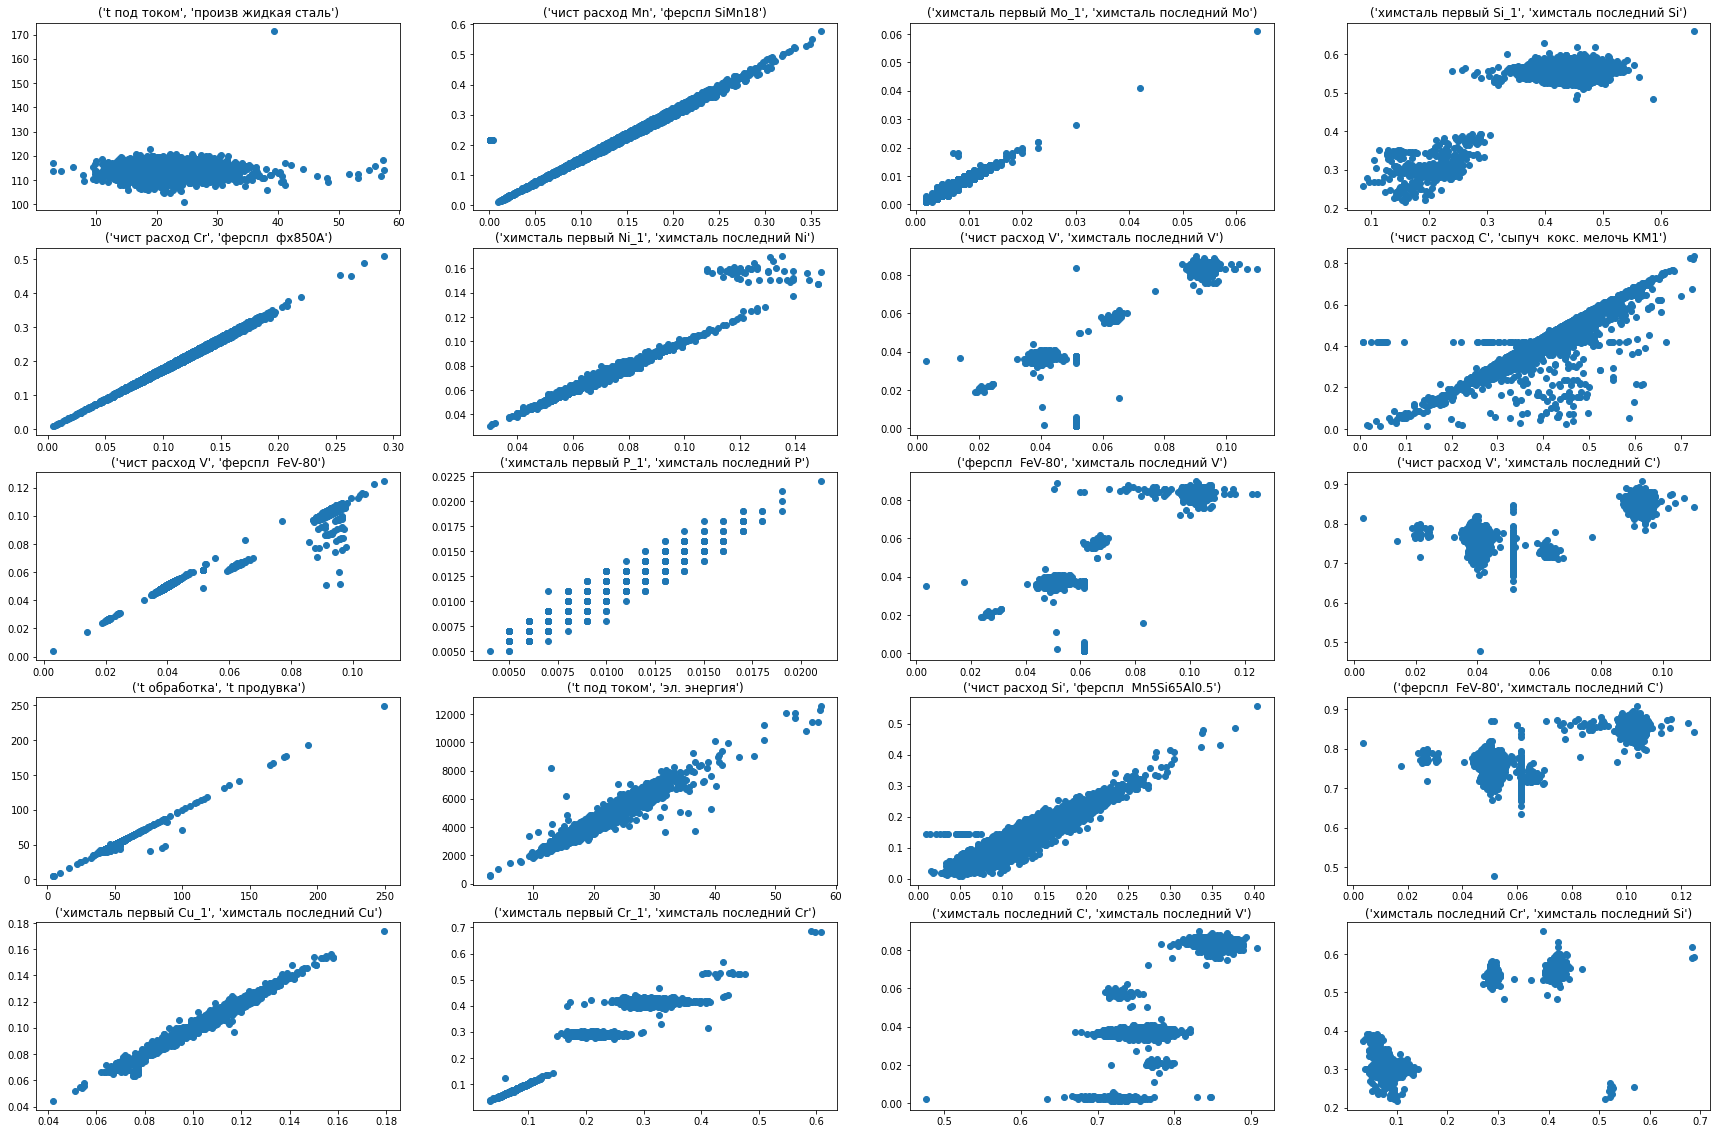

In [17]:
# "Линейность" будем оценивать коээфициентом 
# Из полученных оценок можно построить граф и проверить, нет ли цепочек линейной зависимости
# в случае их присутсвия придется более аккуратно удалять столбцы 
cols_checked = [] # Для уменьшение повторов в анализе, линейная зависимость коммутативна
linearity_graph_edges = []
x_cols = list(X.columns)
for x_col_l in tqdm(range(len(x_cols))):
    x_col_l = x_cols[x_col_l]
    cols_checked.append(x_col_l)
    for x_col_r in x_cols:
        if x_col_r in cols_checked:
            continue
        corr, p = pearsonr(X[x_col_l], X[x_col_r])
        linearity = abs(corr)
        linearity_graph_edges.append((x_cols.index(x_col_l), 
                            x_cols.index(x_col_r),
                            linearity))
linearity_graph_edges.sort(key = lambda v: v[2])

# Можно вывести все остальные графики попарных отношений, но остановимся на топ-20
# У первых шести видна четкая линейность

fig, axs = plt.subplots(5, 4, figsize=(30, 20))
for i in range(20):
    x1, x2, mse_val = linearity_graph_edges[-i]
    axs[i%5, i//5].scatter(X[x_cols[x1]], X[x_cols[x2]])
    axs[i%5, i//5].set_title(f'{x_cols[x1], x_cols[x2]}')

In [18]:
# Удалим один из столбцов из линейных пар
dropped_columns = ['чист расход Mn',
                      'чист расход Cr',
                      'чист расход V',
                      'чист расход Si',
                      'чист расход C',
                      't под током',
                      't обработка',
                      'химсталь первый Cu_1',
                      'химсталь первый Ni_1']
X = X.drop(columns=dropped_columns)
print('Удалены признаки:', dropped_columns)
print(X.shape)

Удалены признаки: ['чист расход Mn', 'чист расход Cr', 'чист расход V', 'чист расход Si', 'чист расход C', 't под током', 't обработка', 'химсталь первый Cu_1', 'химсталь первый Ni_1']
(6285, 51)


In [19]:
# Объединим X и кат празнаки об отсуствии al2o3 и si0
X = pd.concat([X, al2o3_is_na_col, sio2_is_na_col], axis=1)
print("Добавлены признаки под отсуствие полей 'химшлак первый Al2O3_1' и 'химшлак первый SiO2_1', размер теперь:", X.shape)

Добавлены признаки под отсуствие полей 'химшлак первый Al2O3_1' и 'химшлак первый SiO2_1', размер теперь: (6285, 53)


## Корреляции для X и y

<AxesSubplot:>

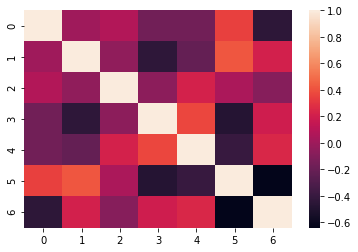

In [24]:
cov = np.corrcoef(np.hstack([X, y]).transpose())
heatmap(cov)

<AxesSubplot:>

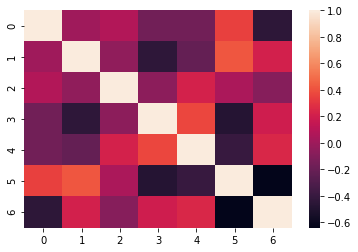

In [21]:
cov = np.corrcoef(y.transpose())
heatmap(cov)

In [22]:
pd.concat([X, y], axis=1).to_csv('dataset_ZavarzinE_(baseline).csv', index=False)

### Выводы: 
* остались скореллированные признаки
* между целевыми признаками есть зависимости